In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
from scipy.stats import norm
import pymc3
import pandas as pd
from numba import jit
from scipy.integrate import solve_ivp

In [39]:
@jit
def cell(t,g,init_x):
    c = np.log(init_x)-g*t[0]
    expo = g*t+c 
    return np.exp(expo)

@jit
def mse(x,y):
    diff=(x-y)**2
    return (1./len(diff))*np.sum(diff)

@jit
def mae(x,y):
    diff=abs(x-y)
    return (1./len(diff))*np.sum(diff)

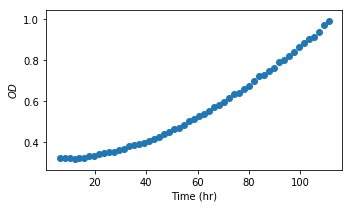

In [96]:
NT=1
col=1
x_data=pd.read_csv("NT10.csv").values
x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
st_index= np.min(np.where(x_clean[:,col]>0))
fin_index = np.min(np.where(x_clean[:,col]>NT))

x = x_clean[st_index:fin_index,col]
t = x_clean[st_index:fin_index,0]/60.0

g = plt.figure(figsize=(5,3))
plt.scatter(t,x)
plt.xlabel('Time (hr)')
plt.ylabel(r'$OD$')
plt.tight_layout()

In [97]:
#### ABC Population monte carlo sampling
####perform ABC here with MSE
L=[200,200,200,200,500,500,500,500,500]
#L=[200,200,200]

iteration=len(L)

#uniform distribution parameters
g_a=0
g_b=0.02

T=t[-1]
sig_array=0.005  #g
typ='Gaussian'
distance=mse
skip=50

est = np.zeros(L[-1])
for idx in range(2):
    g=np.zeros([L[len(L)-1],iteration])  #estimates
    var_g=np.zeros(iteration)            #sample variance
    w=np.zeros([L[len(L)-1],iteration])  #sample weight 
    epsilon=np.zeros(iteration+1)
    epsilon[0]=1
    for k in range(iteration):  #particle filter iteration
        i=0
        score=np.zeros(L[k])
        while i<L[k]:
            y_prop=np.zeros(len(t))
            if k==0:
                prop_g=np.random.uniform(g_a,g_b)
                y_prop=cell(t,prop_g,x[0])
                s=distance(x,y_prop)
                #print(s)
                if s<epsilon[k]:
                    score[i]=s
                    g[i,k]=prop_g
                    w[i,k]=1./L[k]
                    if i%skip==0:
                        print(i,g[i,k],s)
                    i+=1   
            else:
                prop_index = np.random.choice(L[k-1],p=w[:L[k-1],k-1]/np.sum(w[:L[k-1],k-1]))
                prop_var = var_g[k-1] 
                prop_mu = g[prop_index,k-1] 
                if typ=='Gaussian':
                    rep=0
                    while rep==0:
                        prop_g=np.random.normal(prop_mu,prop_var)
                        if prop_g<g_a or prop_g>g_b:
                            rep=0
                        else: 
                            rep=1
                y_prop=cell(t,prop_g,x[0])
                s=distance(x,y_prop)
                if s<epsilon[k]:
                    score[i]=s
                    g[i,k]=prop_g
                    if typ=='Gaussian':
                        kernel_g=norm.pdf((g[:L[k-1],k-1]-prop_g)/np.sqrt(var_g[k-1]),0,1)/np.sqrt(var_g[k-1])
                    w[i,k]=uniform.pdf(prop_g,g_a,g_b)/np.sum(np.multiply(w[:L[k-1],k-1],kernel_g))
                    if i%skip==0:
                        print(i,g[i,k],s)
                    i+=1   
        if typ=="Gaussian":
            var_g[k]=2*np.var(g[:L[k],k])
        epsilon[k+1]=np.quantile(score,0.3)
        print(epsilon[k+1])   
        if k == iteration-1:
            est = g[:,iteration-1]            

0 0.014049947887602133 0.0425694745511954
50 0.014498873425457389 0.055241857661534485
100 0.0016703399418080724 0.07863416231558375
150 0.01910959775267992 0.3723443495119075
0.03099603514018605
0 0.006155450571881085 0.026337426922616022
50 0.0058539074277703836 0.029453424226836587
100 0.008705238696307516 0.005721440837962065
150 0.006195843699446828 0.02592798452883856
0.0034919509333470817
0 0.009792323904858175 0.0016635438648345182
50 0.009231339945157024 0.003291840477399627
100 0.009327883473202575 0.0029367847090571424
150 0.009451748946796873 0.0025254006279278457
0.0014660480996154892
0 0.010613649401338581 0.0014099185631427607
50 0.009960316907557831 0.0013923753238758768
100 0.0103808648111866 0.0011978643695890181
150 0.010315208736941596 0.0011805130124538966
0.0012089845190498302
0 0.010226470053365855 0.0011857699491817913
50 0.010223854292161483 0.0011864188433405322
100 0.010306994787120358 0.0011796225377296813
150 0.010386859819095194 0.0012003613422821716
200 0

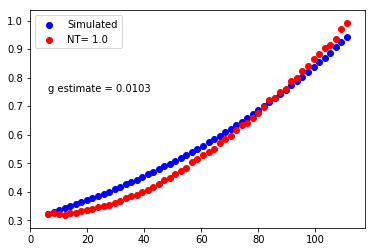

In [99]:
g_est=np.mean(est)
#g_est=0.01
y=cell(t,g_est,x[0])
plt.scatter(t,y,color='b',label='Simulated')
plt.scatter(t,x,color='r',label='NT= %1.1f' %NT)
plt.text(t[0],0.75*NT,'g estimate = %1.4f' %g_est)
plt.legend()


# Estimate the initial condition using Linear Regression

In [73]:
NT=1
col=1
x_data=pd.read_csv("NT10.csv").values
x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
st_index= np.min(np.where(x_clean[:,col]>0))
fin_index = np.min(np.where(x_clean[:,col]>NT))

x = x_clean[st_index:fin_index,col]
t = x_clean[st_index:fin_index,0]/60.0

In [74]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(t.reshape(-1, 1) , np.log(x).reshape(-1, 1) )
print([model.intercept_,model.coef_])

[array([-1.33062429]), array([[0.01169846]])]


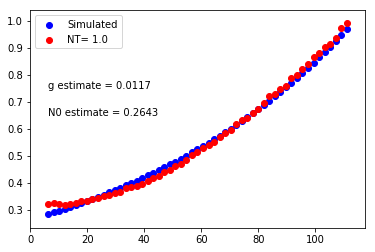

In [75]:
@jit
def cell2(t,a,b):
    return np.exp(a)*np.exp(b*t)

y=cell2(t,model.intercept_,model.coef_)
plt.scatter(t,y,color='b',label='Simulated')
plt.scatter(t,x,color='r',label='NT= %1.1f' %NT)
plt.text(t[0],0.75*NT,'g estimate = %1.4f' %model.coef_)
plt.text(t[0],0.65*NT,'N0 estimate = %1.4f' %np.exp(model.intercept_))
plt.legend()

[array([-1.82972469]), array([[0.01420734]])]


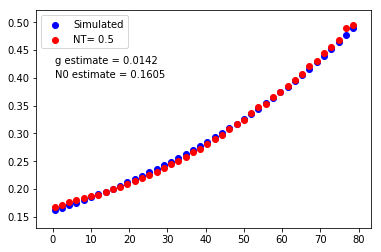

In [79]:
NT=0.5
col=1
x_data=pd.read_csv("NT05.csv").values
x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
st_index= np.min(np.where(x_clean[:,col]>0))
fin_index = np.min(np.where(x_clean[:,col]>NT))

x = x_clean[st_index:fin_index,col]
t = x_clean[st_index:fin_index,0]/60.0
model = LinearRegression().fit(t.reshape(-1, 1) , np.log(x).reshape(-1, 1) )
print([model.intercept_,model.coef_])

y=cell2(t,model.intercept_,model.coef_)
plt.scatter(t,y,color='b',label='Simulated')
plt.scatter(t,x,color='r',label='NT= %1.1f' %NT)
plt.text(t[0],0.85*NT,'g estimate = %1.4f' %model.coef_)
plt.text(t[0],0.8*NT,'N0 estimate = %1.4f' %np.exp(model.intercept_))
plt.legend()

# another method, using curve fit

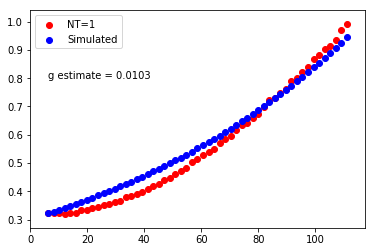

In [103]:
from scipy.optimize import curve_fit
def cell_curve(t,g):
    c = np.log(x[0])-g*t[0]
    expo = g*t+c 
    return np.exp(expo)


NT=1
col=1
x_data=pd.read_csv("NT10.csv").values
x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
st_index= np.min(np.where(x_clean[:,col]>0))
fin_index = np.min(np.where(x_clean[:,col]>NT))

x = x_clean[st_index:fin_index,col]
t = x_clean[st_index:fin_index,0]/60.0
#y = cell_curve(x, 0.1)
popt, pcov = curve_fit(cell_curve, t, x)
plt.scatter(t,x,color='r',label='NT=1')
plt.scatter(t, cell_curve(t, popt),color='b', label='Simulated')
plt.text(t[0],0.8*NT,'g estimate = %1.4f' %popt)
plt.legend()

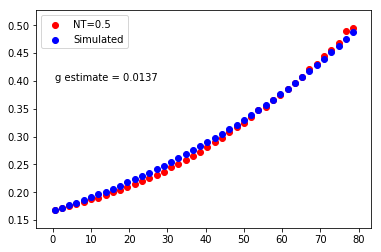

In [102]:
NT=0.5
col=1
x_data=pd.read_csv("NT05.csv").values
x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
st_index= np.min(np.where(x_clean[:,col]>0))
fin_index = np.min(np.where(x_clean[:,col]>NT))

x = x_clean[st_index:fin_index,col]
t = x_clean[st_index:fin_index,0]/60.0
popt, pcov = curve_fit(cell_curve, t, x)
plt.scatter(t,x,color='r',label='NT=0.5')
plt.scatter(t, cell_curve(t, popt),color='b', label='Simulated')
plt.text(t[0],0.8*NT,'g estimate = %1.4f' %popt)
plt.legend()

# With lag phase

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
from scipy.stats import norm
import pymc3
import pandas as pd
from numba import jit
from scipy.integrate import solve_ivp

In [9]:
@jit
def cell(t,z,g,K,q0):
    beta= q0/(q0+np.exp(-g*t))
    N=r*z[0]*(1-(z[0]/K))*beta
    return N

@jit
def mse(x,y):
    diff=(x-y)**2
    s=np.shape(diff)
    return (1./(s[0]*s[1]))*np.sum(diff)

@jit
def mae(x,y):
    diff=abs(x-y)
    s=np.shape(diff)
    return (1./(s[0]*s[1]))*np.sum(diff)

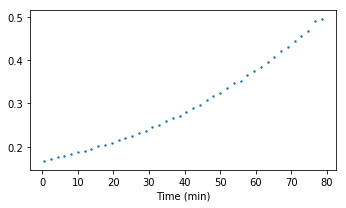

In [10]:
NT=0.5
col=1
x_data=pd.read_csv("NT05.csv").values
x_clean=np.delete(x_data,np.where(x_data[:,1]<0),axis=0)
st_index= np.min(np.where(x_clean[:,col]>0))
fin_index = np.min(np.where(x_clean[:,col]>NT))

x = x_clean[st_index:fin_index,col]
t = x_clean[st_index:fin_index,0]/60.0

g = plt.figure(figsize=(5,3))

plt.scatter(t,x,s=2)
plt.xlabel('Time (min)')
plt.tight_layout()

In [8]:
#### ABC Population monte carlo sampling
####perform ABC here with MSE
#L=[200,200,200,200,500,500,500,500,500]
L=[200,200,200,500,500,500,500,500,500]
iteration=len(L)

#samples, weights, sigma


#uniform distribution parameters
r_a=0
r_b=2
K_a=1.5
K_b=2
q0_a=0
q0_b=1
m_a=0
m_b=5

T=t[-1]
init_Nm=N[0,:,0]

sig_array=[0.05,0.05,0.05,0.05]  #[rm,rd,K]
typ='Gaussian'
distance=mse
skip=50


est = np.zeros([L[-1],4,2])
for idx in range(2):
    rm=np.zeros([L[len(L)-1],iteration])
    K=np.zeros([L[len(L)-1],iteration])
    q0=np.zeros([L[len(L)-1],iteration])
    m=np.zeros([L[len(L)-1],iteration])
    var_rm=np.zeros(iteration)
    var_K=np.zeros(iteration)
    var_q0=np.zeros(iteration)
    var_m=np.zeros(iteration)
    w=np.zeros([L[len(L)-1],iteration])
    epsilon=np.zeros(iteration+1)
    epsilon[0]=1
    for k in range(iteration):  #particle filter iteration
        i=0
        score=np.zeros(L[k])
        while i<L[k]:
            y_prop=np.zeros([len(t),3])
            prop=np.zeros(4)  #remove for gaussian
            if k==0:
                prop_rm=np.random.uniform(r_a,r_b)
                prop_K=np.random.uniform(K_a,K_b)  
                prop_q0=np.random.uniform(q0_a,q0_b)
                prop_m=np.random.uniform(m_a,m_b)  
                for j in range(3):
                    sol = solve_ivp(lambda t, z: cell(t, z,prop_rm,prop_K,prop_q0,prop_m), [0, T], [init_Nm[j]],dense_output=True)
                    y_prop[:,j] =np.ndarray.flatten(sol.sol(t))
                s=distance(N[:,:,idx],y_prop)
                #print(s)
                if s<epsilon[k]:
                    score[i]=s
                    rm[i,k]=prop_rm
                    K[i,k]=prop_K  
                    q0[i,k]=prop_q0
                    m[i,k]=prop_m  
                    w[i,k]=1./L[k]
                    if i%skip==0:
                        print(i,k,rm[i,k],K[i,k],q0[i,k],m[i,k],s)
                    i+=1   
            else:
                prop_index = np.random.choice(L[k-1],p=w[:L[k-1],k-1]/np.sum(w[:L[k-1],k-1]))
                prop_var = np.diag([var_rm[k-1],var_K[k-1],var_q0[k-1],var_m[k-1]]) 
                prop_mu = np.array([rm[prop_index,k-1],K[prop_index,k-1],q0[prop_index,k-1],m[prop_index,k-1]]) 
                summ=-1
                while summ<2:
                    if typ=='Gaussian':
                        rep=0
                        while rep==0:
                            prop=np.random.multivariate_normal(prop_mu,prop_var)
                            if prop[0]>r_b or prop[2]>q0_b or prop[3]>m_b or prop[1]>K_b or prop[1]<K_a or prop[0]<r_a or prop[2]<q0_a or prop[3]<m_a:
                                rep=0
                            else: 
                                rep=1
                    else:
                        for kk in range(4):
                            prop[kk]=prop_mu[kk]+sig_array[kk]*np.random.uniform(-1,1) 
                    dummy=prop>0
                    summ=np.sum(dummy)
                #print(prop)
                for j in range(3):
                    sol = solve_ivp(lambda t, z: cell(t, z,prop[0],prop[1],prop[2],prop[3]), [0, T], [init_Nm[j]],dense_output=True)
                    y_prop[:,j] =np.ndarray.flatten(sol.sol(t))
                s=distance(N[:,:,idx],y_prop)
                #print(s)
                if s<epsilon[k]:
                    score[i]=s
                    rm[i,k]=prop[0]
                    K[i,k]=prop[1]  
                    q0[i,k]=prop[2]
                    m[i,k]=prop[3]  
                    if typ=='Gaussian':
                        kernel_rm=norm.pdf((rm[:L[k-1],k-1]-prop[0])/np.sqrt(var_rm[k-1]),0,1)/np.sqrt(var_rm[k-1])
                        kernel_K=norm.pdf((K[:L[k-1],k-1]-prop[1])/np.sqrt(var_K[k-1]),0,1)/np.sqrt(var_K[k-1])
                        kernel_q0=norm.pdf((q0[:L[k-1],k-1]-prop[2])/np.sqrt(var_q0[k-1]),0,1)/np.sqrt(var_q0[k-1])
                        kernel_m=norm.pdf((m[:L[k-1],k-1]-prop[3])/np.sqrt(var_m[k-1]),0,1)/np.sqrt(var_m[k-1])
                    else:
                        kernel_rm=uniform.pdf(prop[0],-1*sig_array[0]+prop_mu[0],1*sig_array[0]+prop_mu[0])
                        kernel_K=uniform.pdf(prop[1],-1*sig_array[1]+prop_mu[1],1*sig_array[1]+prop_mu[1])
                        kernel_q0=uniform.pdf(prop[2],-1*sig_array[2]+prop_mu[2],1*sig_array[2]+prop_mu[2])
                        kernel_m=uniform.pdf(prop[3],-1*sig_array[3]+prop_mu[3],1*sig_array[3]+prop_mu[3])
                        
                    w[i,k]=(uniform.pdf(prop[0],r_a,r_b)*uniform.pdf(prop[1],K_a,K_b)*uniform.pdf(prop[2],q0_a,q0_b)*uniform.pdf(prop[3],m_a,m_b))/np.sum(np.multiply(w[:L[k-1],k-1],kernel_rm*kernel_K*kernel_q0*kernel_m))
                    #print('done')
                    if i%skip==0:
                        print(i,k,rm[i,k],K[i,k],q0[i,k],m[i,k],s)
                    i+=1   
        if typ=="Gaussian":
            var_rm[k]=2*np.var(rm[:L[k],k])
            var_K[k]=2*np.var(K[:L[k],k])  
            var_q0[k]=2*np.var(q0[:L[k],k])
            var_m[k]=2*np.var(m[:L[k],k])  
        epsilon[k+1]=np.quantile(score,0.3)
        print(epsilon[k+1])   
        
        if k == iteration-1:
            est[:,0,idx] = rm[:,iteration-1]
            est[:,1,idx] = K[:,iteration-1]
            est[:,2,idx] = q0[:,iteration-1]
            est[:,3,idx] = m[:,iteration-1]

NameError: name 'N' is not defined